In [1]:
import torch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import torch.nn as nn
from tqdm import tqdm
from sklearn.cluster import KMeans
from torch.utils.data import DataLoader, TensorDataset
from scipy.stats import pearsonr
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [2]:
# Load data
train_data = torch.load('train.pt')
val_data = torch.load('val.pt')
test_data = torch.load('test.pt')

In [3]:
# Prepare dataset
def prepare_dataset(data):
    eeg_list = []
    stim_list = []
    for eeg, stim in data:
        eeg_list.append(eeg.float())           # (320, 64)
        stim_list.append(stim.float())         # (320,)
    eeg_tensor = torch.stack(eeg_list)         # (N, 320, 64)
    stim_tensor = torch.stack(stim_list)       # (N, 320)
    return eeg_tensor, stim_tensor

X_train, y_train = prepare_dataset(train_data)
X_val, y_val = prepare_dataset(val_data)
X_test, y_test = prepare_dataset(test_data)

In [4]:
# Pearson Correlation Loss
class PearsonCorrelationLoss(nn.Module):
    def __init__(self):
        super(PearsonCorrelationLoss, self).__init__()

    def forward(self, pred, target):
        pred = pred - pred.mean(dim=1, keepdim=True)
        target = target - target.mean(dim=1, keepdim=True)

        numerator = (pred * target).sum(dim=1)
        denominator = torch.sqrt((pred ** 2).sum(dim=1) * (target ** 2).sum(dim=1) + 1e-8)

        correlation = numerator / denominator
        return -correlation.mean()

In [9]:
# Model without skip connection
class CNNLSTMNoSkip(nn.Module):
    def __init__(self, in_channels=64, lstm_hidden_dim=64):
        super(CNNLSTMNoSkip, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Conv1d(128, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(64)
        )

        self.lstm1 = nn.LSTM(input_size=64, hidden_size=lstm_hidden_dim, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(input_size=2 * lstm_hidden_dim, hidden_size=lstm_hidden_dim, batch_first=True, bidirectional=True)
        self.regressor = nn.Linear(2 * lstm_hidden_dim, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)          # (B, 64, 320)
        x = self.cnn(x)                 # (B, 64, 320)
        x = x.permute(0, 2, 1)          # (B, 320, 64)
        x, _ = self.lstm1(x)            # (B, 320, 2*H)
        x, _ = self.lstm2(x)            # (B, 320, 2*H)
        x = self.regressor(x)          # (B, 320, 1)
        x = F.relu(x)     
        x = x.squeeze(-1)              # (B, 320)
        return x

In [10]:
# DataLoaders
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)

In [11]:
# Initialize model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNLSTMNoSkip().to(device)
loss_fn = PearsonCorrelationLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [12]:
# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

    for x_batch, y_batch in progress_bar:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        avg_loss = running_loss / (progress_bar.n + 1)
        progress_bar.set_postfix(train_loss=avg_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)
            val_loss += loss_fn(pred, y_batch).item()
    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_loss:.4f} - Val Loss: {val_loss:.4f}")

Epoch 1/10 - Train Loss: -0.1233 - Val Loss: -0.1322


Epoch 2/10 - Train Loss: -0.1464 - Val Loss: -0.1438


Epoch 3/10 - Train Loss: -0.1593 - Val Loss: -0.1533


Epoch 4/10 - Train Loss: -0.1690 - Val Loss: -0.1579


Epoch 5/10 - Train Loss: -0.1781 - Val Loss: -0.1608


Epoch 6/10 - Train Loss: -0.1866 - Val Loss: -0.1625


Epoch 7/10 - Train Loss: -0.1945 - Val Loss: -0.1644


Epoch 8/10 - Train Loss: -0.2026 - Val Loss: -0.1620


Epoch 9/10 - Train Loss: -0.2104 - Val Loss: -0.1611


Epoch 10/10 - Train Loss: -0.2193 - Val Loss: -0.1592


In [13]:
model.eval()
val_loss = 0.0
cos_sims = []

with torch.no_grad():
    for x_batch, y_batch in val_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        pred = model(x_batch)

        val_loss += loss_fn(pred, y_batch).item()

        # Cosine similarity (batch-wise)
        pred_np = pred.cpu().numpy()
        target_np = y_batch.cpu().numpy()
        for p, t in zip(pred_np, target_np):
            sim = cosine_similarity(p.reshape(1, -1), t.reshape(1, -1))[0][0]
            cos_sims.append(sim)

val_loss /= len(val_loader)
avg_cos_sim = np.mean(cos_sims)

print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_loss:.4f} - Val Loss: {val_loss:.4f} - Cosine Similarity: {avg_cos_sim:.4f}")

Epoch 10/10 - Train Loss: -0.2193 - Val Loss: -0.1592 - Cosine Similarity: 0.8089


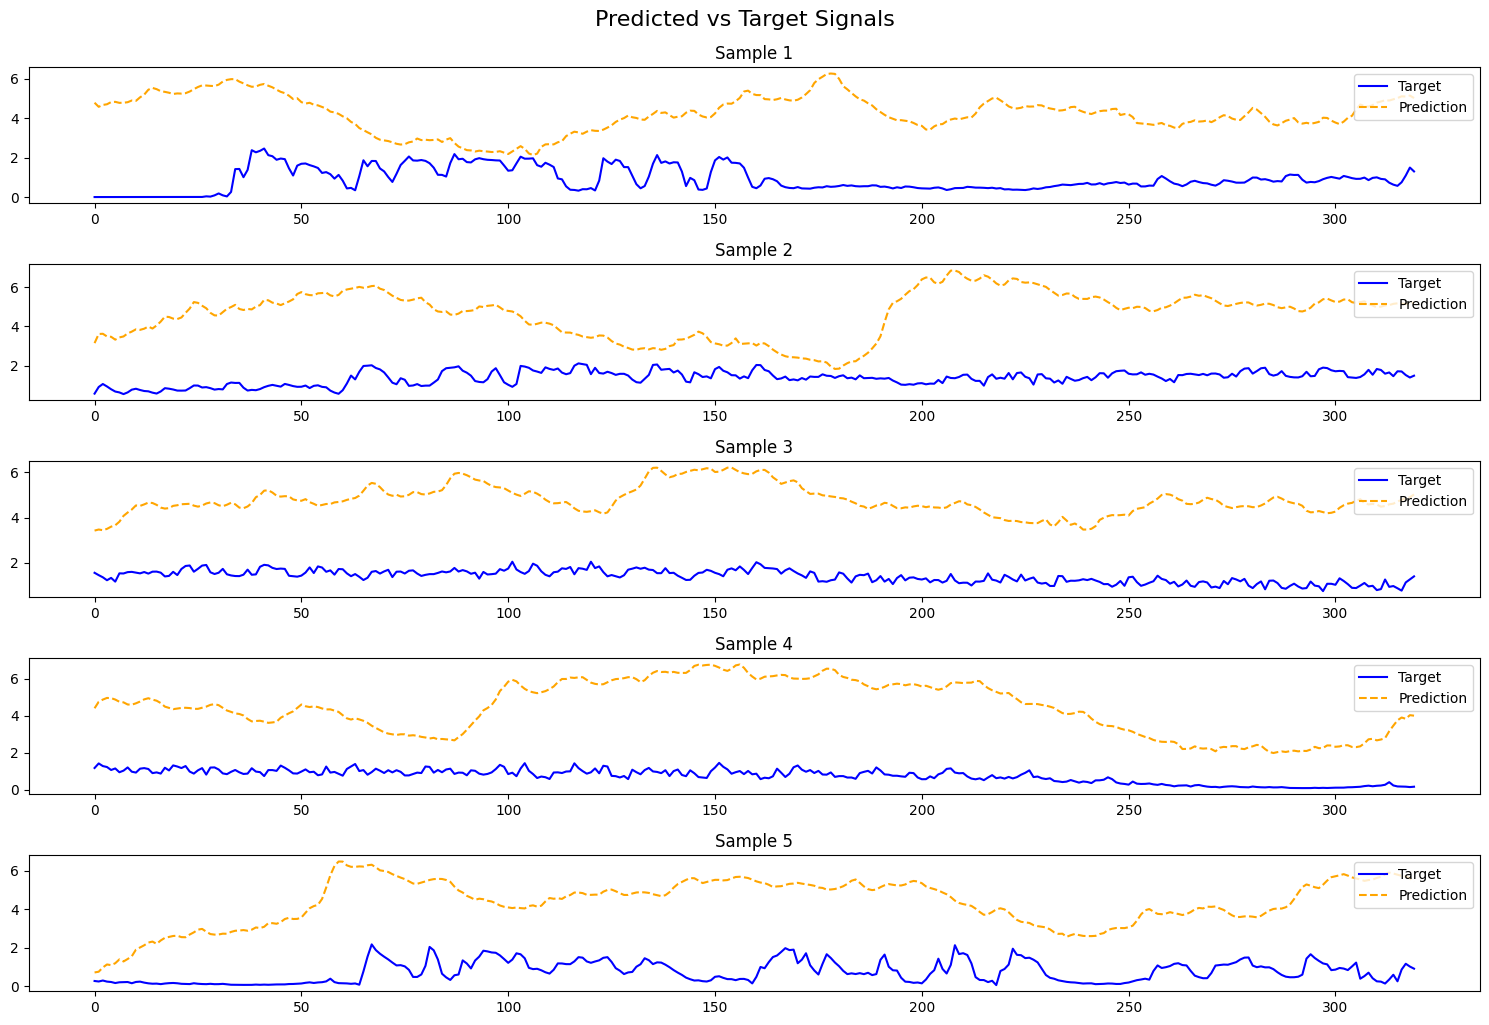

In [14]:
model.eval()
with torch.no_grad():
    x_batch, y_batch = next(iter(test_loader))
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    pred = model(x_batch)

# Move to CPU for plotting
pred = pred.cpu().numpy()
y_batch = y_batch.cpu().numpy()

# Plot a few samples
n_samples = 5
plt.figure(figsize=(15, 10))
for i in range(n_samples):
    plt.subplot(n_samples, 1, i + 1)
    plt.plot(y_batch[i], label="Target", color='blue', linewidth=1.5)
    plt.plot(pred[i], label="Prediction", color='orange', linestyle='--', linewidth=1.5)
    plt.title(f"Sample {i + 1}")
    plt.legend(loc='upper right')
    plt.tight_layout()

plt.suptitle("Predicted vs Target Signals", fontsize=16, y=1.02)
plt.show()